# <font color='red'>**Sequence to sequence implementation**</font>

**There will be some functions that start with the word "grader" ex: grader_check_encoder(), grader_check_attention(), grader_onestepdecoder() etc, you should not change those function definition.<br><br>Every Grader function has to return True.**

**Note 1:**  There are many blogs on the attention mechanisum which might be misleading you,
 so do read the references completly and after that only please check the internet.
 The best things is to read the research papers and try to implement it on your own. 

**Note 2:** To complete this assignment, the reference that are mentioned will be enough.

**Note 3:** If you are starting this assignment, you might have completed minimum of 20 assignment.
 If  you are still not able to implement this algorithm you might have rushed in the previous assignments 
with out learning much and didn't spend your time productively.

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data this way only: 
<img src='https://i.imgur.com/z0j79Jf.png'>    
    
3. You have to implement a simple Encoder and Decoder architecture  

4. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

5. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

6.  a. Check the reference notebook <br>
    b. <a href="https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb">Resource 2</a>
    



<font color='blue'>**Load the data**</font>

In [6]:
!wget http://www.manythings.org/anki/ita-eng.zip
!unzip ita-eng.zip

--2022-04-26 11:36:27--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7757958 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.40M  --.-KB/s    in 0.03s   

2022-04-26 11:36:27 (241 MB/s) - ‘ita-eng.zip’ saved [7757958/7757958]

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [7]:
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-04-26 11:36:28--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-04-26 11:36:28--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb94a0398863626cc3a2ec08962.dl.dropboxusercontent.com/cd/0/inline/BkLuNs_PzKl6qG4_wtYOMj47f2HKZ_DOShOX4t_XuqIXZIUY73WsbiCQaLSaqdzMJKkB2NMgbHlMGVaf4Bdx6rjgXqHglrqZL-6QB5UKy537Nj-o4_8KQthcF4Tj_cJD-2RcNlpNp9IZAO_Cf-BoD0gsiHlvLh6s7gn1XGuS2u01xA/file# [following]
--2022-04-26 11:36:29--  https://ucb94a0398863626cc3a2ec08962.dl.dropboxusercontent.com/cd/0/inline/BkLuNs_PzKl6qG4_wtYOMj47f2HKZ_DOShOX4t_XuqIXZIUY73

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [9]:
data = []
with open("ita.txt" , "r", encoding = 'utf8') as f:
  for i,line in enumerate(f.readlines()):    
    data.append(tuple(line.split('\t')[:2]))
    
   

In [10]:
df = pd.DataFrame(data = data, columns=["english","italian"])
df.head()


,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


In [11]:
print(df.shape)
df.drop_duplicates()
print(df.shape)

(353281, 2)
(353281, 2)


In [12]:
#credits : applied roots reference notebook
#has seen these codes many times and can apply easily but just for convinence have borrowed them
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


df['english'] = df['english'].apply(preprocess)
df['italian'] = df['italian'].apply(preprocess_ita)
df.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [13]:
ita_lengths = df['italian'].str.split().apply(len)
eng_lengths = df['english'].str.split().apply(len)

In [14]:
for i in range(0,101,10):
    print(i,np.percentile(ita_lengths, i))
for i in range(90,101):
    print(i,np.percentile(ita_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(ita_lengths, i))

0 1.0
10 3.0
20 4.0
30 4.0
40 5.0
50 5.0
60 6.0
70 6.0
80 7.0
90 8.0
100 92.0
90 8.0
91 8.0
92 8.0
93 9.0
94 9.0
95 9.0
96 9.0
97 10.0
98 11.0
99 12.0
100 92.0
99.1 12.0
99.2 12.0
99.3 13.0
99.4 13.0
99.5 13.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 22.0
100 92.0


In [15]:
for i in range(0,101,10):
    print(i,np.percentile(eng_lengths, i))
for i in range(90,101):
    print(i,np.percentile(eng_lengths, i))
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print(i,np.percentile(eng_lengths, i))

0 1.0
10 4.0
20 4.0
30 5.0
40 5.0
50 6.0
60 6.0
70 7.0
80 7.0
90 8.0
100 101.0
90 8.0
91 9.0
92 9.0
93 9.0
94 9.0
95 9.0
96 10.0
97 10.0
98 11.0
99 12.0
100 101.0
99.1 12.0
99.2 13.0
99.3 13.0
99.4 13.0
99.5 14.0
99.6 14.0
99.7 15.0
99.8 16.0
99.9 25.0
100 101.0


<font color='blue'>**Preprocess data**</font>

In [16]:
df['italian_len'] = df['italian'].str.split().apply(len)
df = df[df['italian_len'] < 22]

df['english_len'] = df['english'].str.split().apply(len)
df = df[df['english_len'] < 22]

df['english_inp'] = '<start> ' + df['english'].astype(str)
df['english_out'] = df['english'].astype(str) + ' <end>'

df = df.drop(['english','italian_len','english_len'], axis=1)
# only for the first sentance add a toke <end> so that we will have <end> in tokenizer
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,ciao,<start> hi,hi <end>
2,corri,<start> run,run <end>
3,corra,<start> run,run <end>
4,correte,<start> run,run <end>


In [17]:
df.isna().sum()

italian        0
english_inp    0
english_out    0
dtype: int64

In [18]:
df_reverse = df

In [19]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state = 42)
print(train.shape, validation.shape)
# for one sentence we will be adding <end> token so that the tokanizer learns the word <end>
# with this we can use only one tokenizer for both encoder output and decoder output
train.iloc[0]['english_inp']= str(train.iloc[0]['english_inp'])+' <end>'
train.iloc[0]['english_out']= str(train.iloc[0]['english_out'])+' <end>'

(282292, 3) (70573, 3)


In [20]:
#validation, test = train_test_split(validation,test_size = 0.4, random_state=42)

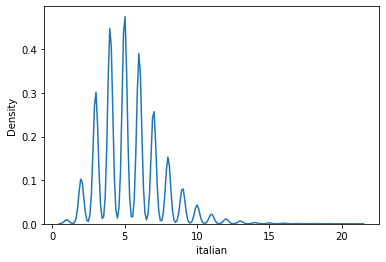

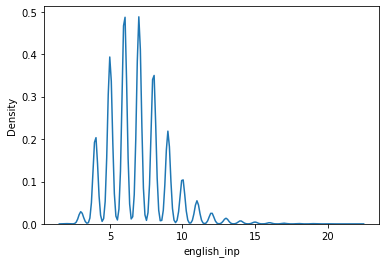

In [21]:
ita_lengths = train['italian'].str.split().apply(len)
eng_lengths = train['english_inp'].str.split().apply(len)
import seaborn as sns
sns.kdeplot(ita_lengths)
plt.show()
sns.kdeplot(eng_lengths)
plt.show()

In [22]:
tknizer_ita = Tokenizer()
tknizer_ita.fit_on_texts(train['italian'].values)
tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [23]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print("vocab size of english",vocab_size_eng)
vocab_size_ita=len(tknizer_ita.word_index.keys())
print("vocab size of italian",vocab_size_ita)

vocab size of english 13107
vocab size of italian 26596


In [24]:
#check the tokenized numerical value of <end> and <start>
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10319)

In [25]:
#embedding the tokenised texts
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size_eng+1, 100))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [26]:
tknizer_eng.word_index.items()

dict_items([('<start>', 1), ('i', 2), ('you', 3), ('tom', 4), ('to', 5), ('is', 6), ('not', 7), ('the', 8), ('do', 9), ('a', 10), ('are', 11), ('have', 12), ('it', 13), ('that', 14), ('he', 15), ('was', 16), ('am', 17), ('in', 18), ('we', 19), ('me', 20), ('will', 21), ('did', 22), ('of', 23), ('this', 24), ('be', 25), ('what', 26), ('can', 27), ('for', 28), ('my', 29), ('your', 30), ('want', 31), ('mary', 32), ('with', 33), ('like', 34), ('why', 35), ('know', 36), ('think', 37), ('go', 38), ('she', 39), ('his', 40), ('here', 41), ('at', 42), ('they', 43), ('would', 44), ('very', 45), ('on', 46), ('and', 47), ('how', 48), ('has', 49), ('there', 50), ('does', 51), ('about', 52), ('now', 53), ('were', 54), ('all', 55), ('going', 56), ('so', 57), ('should', 58), ('need', 59), ('get', 60), ('as', 61), ('boston', 62), ('help', 63), ('time', 64), ('us', 65), ('him', 66), ('an', 67), ('good', 68), ('tell', 69), ('who', 70), ('one', 71), ('had', 72), ('really', 73), ('never', 74), ('still', 75

In [27]:
train.head()

,italian,english_inp,english_out
63501,non cè caldo oggi,<start> it is not hot today <end>,it is not hot today <end> <end>
227738,non osare toccare nulla,<start> do not you dare touch anything,do not you dare touch anything <end>
241713,tutti hanno detto che io avevo torto,<start> everyone said that i was wrong,everyone said that i was wrong <end>
200152,io spero di vederti la prossima volta,<start> i hope to see you next time,i hope to see you next time <end>
216938,sono andata a fare trekking con il gruppo,<start> i went hiking with the group,i went hiking with the group <end>


In [28]:
def reverse_text(s):
  s = " ".join([ c for c in reversed(s.split())])
  return s
print(reverse_text("I am great machine learning engineer"))

engineer learning machine great am I


In [29]:
train_rev = train.copy()
validation_rev = validation.copy()


def reverse_text(s):
  s = " ".join([ c for c in reversed(s.split())])
  return s

train_rev.italian = train_rev.italian.apply(reverse_text)
validation_rev.italian = validation_rev.italian.apply(reverse_text)

In [30]:
train_rev.head()

,italian,english_inp,english_out
63501,oggi caldo cè non,<start> it is not hot today <end>,it is not hot today <end> <end>
227738,nulla toccare osare non,<start> do not you dare touch anything,do not you dare touch anything <end>
241713,torto avevo io che detto hanno tutti,<start> everyone said that i was wrong,everyone said that i was wrong <end>
200152,volta prossima la vederti di spero io,<start> i hope to see you next time,i hope to see you next time <end>
216938,gruppo il con trekking fare a andata sono,<start> i went hiking with the group,i went hiking with the group <end>


In [31]:
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [32]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, 22)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, 22)
BATCH = 64
train_dataloader = Dataloder(train_dataset, batch_size= BATCH)
test_dataloader = Dataloder(test_dataset, batch_size= BATCH)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 22) (64, 22) (64, 22)


In [33]:
print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(64, 22) (64, 22) (64, 22)


In [34]:
print(train_dataloader[0][0])

[array([[    2,   108,   614, ...,     0,     0,     0],
       [    2, 12634,  2072, ...,     0,     0,     0],
       [   77,   115,    57, ...,     0,     0,     0],
       ...,
       [    2,    15,    63, ...,     0,     0,     0],
       [14941,     9,   307, ...,     0,     0,     0],
       [    1,    26,    40, ...,     0,     0,     0]], dtype=int32), array([[   1,   13,    6, ...,    0,    0,    0],
       [   1,    9,    7, ...,    0,    0,    0],
       [   1,  193,   94, ...,    0,    0,    0],
       ...,
       [   1,    3,   74, ...,    0,    0,    0],
       [   1,   19, 4099, ...,    0,    0,    0],
       [   1,    4,    6, ...,    0,    0,    0]], dtype=int32)]


## <font color='blue'>**Implement custom encoder decoder**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
#@title Default title text
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.lstm_units = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True, name="embedding")
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="encoder_lstm")


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embed = self.embedding(input_sequence)
        #print("ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE :",input_embedd.shape)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embed, initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      #self.lstm_output = 0
      lstm_state_h= np.zeros((batch_size, self.lstm_units))
      lstm_state_c= np.zeros((batch_size, self.lstm_units))
      return [tf.keras.backend.constant(lstm_state_h) , tf.keras.backend.constant(lstm_state_c)]


<font color='orange'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units,
        input_length: Length of the input sentence,
        batch_size
    '''
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    #Intialzing encoder 
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    #Intializing encoder initial states
    initial_state=encoder.initialize_states(batch_size)
    
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()

        #Initialize Embedding layer
        #Intialize Decoder LSTM layer
        self.embedding = Embedding(input_dim=out_vocab_size,output_dim= embedding_size,input_length= input_length , mask_zero= True, name="embedding_dec")
        self.lstm = LSTM(units= lstm_size, return_sequences= True, return_state=True, name ="lstm_dec")
        

    def call(self,input_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        target_embedd   = self.embedding(input_sequence)    
        lstm_output, h,c  = self.lstm(target_embedd, initial_state=initial_states)
        return lstm_output,h,c # the final lstm_output which is returned is of shape (batch, num_of_sentences, lstm_units)

      


<font color='orange'>**Grader function - 2**</font>

In [ ]:
def grader_decoder():
    '''
        out_vocab_size: Unique words of the target language,
        embedding_size: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        input_length: Length of the input sentence,
        batch_size
        
    
    '''
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    states=[state_h,state_c]
    decoder=Decoder(out_vocab_size, embedding_dim, dec_units,input_length )
    output,_,_=decoder(target_sentences, states)
    assert(output.shape==(batch_size,input_length,dec_units))
    return True
print(grader_decoder())


True


In [ ]:
class Encoder_decoder(tf.keras.Model):
    #encoder_inputs_length,decoder_inputs_length, output_vocab_size
    def __init__(self,output_vocab_size, encoder_inputs_length,decoder_inputs_length, *params):
        super().__init__()
        #Create encoder object
        #Create decoder object
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.encoder = Encoder(inp_vocab_size= vocab_size_ita+1, embedding_size= 50, input_length=encoder_inputs_length, lstm_size= 128)
        self.decoder = Decoder(out_vocab_size= vocab_size_eng+1, embedding_size= 100, input_length=decoder_inputs_length, lstm_size= 128)
        self.dense   = Dense(output_vocab_size, activation='softmax')
  #inp_vocab_size,embedding_size,lstm_size,input_length):       
   #out_vocab_size,embedding_size,lstm_size,input_length):

    
    def call(self,data,*params):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input_sequence , output_sequence = data[0], data[1]
        print("gh", output_sequence.shape)
        
        enc_output, enc_final_state_h, encoder_final_state_c = self.encoder(input_sequence, self.encoder.initialize_states(BATCH) )
        dec_output, _ , _ = self.decoder(output_sequence, [enc_final_state_h, encoder_final_state_c ] )
        #in teacher forcing, we donot pass dec_output to the lstm at the next instance.
        # we pass what we have already have kept in column 'english_input' 
        # suppose we have an italian sentence encoded as e vector. we pass this as hidden state to decoder lstm and as input we pass <start>
        # whose dimension is 100 , here, and its output, i.e, dec_output comes as 100 dimensional vector which is softmaxed into 
        # number of classes(vocabulary size of english ), and argmax of that is the first translated word, first_en
        # what is role of this first_en ?
        # it will just help to calculate loss by comparing it to the first word of the corresponding sentence under 'english_output' column
        # will not first_en be passed further to the next timestamp LSTM?
        # NO. for the next decoder LSTM,  we take the 2nd word of the sentence under 'english_inpuut' col and pass that
        # In other words, we are forcing the inputs and hoping the decoder lstm to predict the correct next word 
        # how successful is our hope is calculated by the word predicted by decoder LSTM 
        # doubt : the final decoder output is of shape (batch , num_of_words_in_padded_sentence, dec_lstm_units) which is changed to
        # (batch, num_of_words_in_padded_sentence, english_vocab)
        # i.e, for each word_to_be in padded sentence that is input_to_decoder, we have a probability distribution over all the words present in the vocabulary
        # the one which has the highest probab is the predicted word_to_be for that sentence
        # and the ground truth is of shape: (batch, num_of_words)
        
        output = self.dense(dec_output)
        return output
        

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model#,inp_vocab_size,embedding_size,lstm_size,input_length):
model = Encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=22,output_vocab_size=vocab_size_eng)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath= "model/cp.ckpt",
      save_weights_only=True, 
      save_best_only = True,
      monitor='val_loss',
      mode='min', verbose =1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor= 0.8, mode='auto', verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2, restore_best_weights=True, mode ='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])
train_steps=train.shape[0]//BATCH
valid_steps=validation.shape[0]//BATCH

#optimizer = tf.keras.optimizers.Adam(1e-3)
# ...


model.fit(train_dataloader, steps_per_epoch=train_steps, epochs= 20, validation_data= train_dataloader,  callbacks = [model_checkpoint_callback , reduce_lr, early])
model.summary()

gh (64, 22)
Epoch 1/20
gh (None, None)
gh (None, None)
4410/4410 [==============================] - ETA: 0s - loss: 0.7701 - accuracy: 0.5597gh (None, None)

Epoch 1: val_loss improved from inf to 0.40318, saving model to model/cp.ckpt
4410/4410 [==============================] - 337s 75ms/step - loss: 0.7701 - accuracy: 0.5597 - val_loss: 0.4032 - val_accuracy: 0.7269 - lr: 0.0050
Epoch 2/20
4410/4410 [==============================] - ETA: 0s - loss: 0.3463 - accuracy: 0.7593
Epoch 2: val_loss improved from 0.40318 to 0.24278, saving model to model/cp.ckpt
4410/4410 [==============================] - 330s 75ms/step - loss: 0.3463 - accuracy: 0.7593 - val_loss: 0.2428 - val_accuracy: 0.8164 - lr: 0.0050
Epoch 3/20
4409/4410 [============================>.] - ETA: 0s - loss: 0.2434 - accuracy: 0.8152
Epoch 3: val_loss improved from 0.24278 to 0.18718, saving model to model/cp.ckpt
4410/4410 [==============================] - 330s 75ms/step - loss: 0.2434 - accuracy: 0.8152 - val_loss: 

KeyboardInterrupt: ignored

In [ ]:
#20 epochs , log loss =0.0787, bleu_score(10% random test data) = 81.4%
# I will experiment now with reversing the italian texts


In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model#,inp_vocab_size,embedding_size,lstm_size,input_length):
model_rev = Encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=22,output_vocab_size=vocab_size_eng)
model_checkpoint_callback_rev = tf.keras.callbacks.ModelCheckpoint(
      filepath= "model_rev/cp.ckpt",
      save_weights_only=True, 
      save_best_only = True,
      monitor='val_loss',
      mode='min', verbose =1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor= 0.8, mode='auto', verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2, restore_best_weights=True, mode ='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)

model_rev.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])
train_steps=train_rev.shape[0]//BATCH
valid_steps=validation_rev.shape[0]//BATCH

#optimizer = tf.keras.optimizers.Adam(1e-3)
# ...


model_rev.fit(train_dataloader_rev, steps_per_epoch=train_steps, epochs= 20, validation_data= train_dataloader_rev,  callbacks = [model_checkpoint_callback_rev , reduce_lr, early])
model_rev.summary()

Epoch 1/20
275/275 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.2093
Epoch 1: val_loss improved from inf to 1.35040, saving model to model_rev/cp.ckpt
275/275 [==============================] - 73s 246ms/step - loss: 1.5909 - accuracy: 0.2093 - val_loss: 1.3504 - val_accuracy: 0.2661 - lr: 0.0050
Epoch 2/20
275/275 [==============================] - ETA: 0s - loss: 1.1705 - accuracy: 0.3538
Epoch 2: val_loss improved from 1.35040 to 1.00101, saving model to model_rev/cp.ckpt
275/275 [==============================] - 66s 238ms/step - loss: 1.1705 - accuracy: 0.3538 - val_loss: 1.0010 - val_accuracy: 0.4384 - lr: 0.0050
Epoch 3/20
275/275 [==============================] - ETA: 0s - loss: 0.9028 - accuracy: 0.4851
Epoch 3: val_loss improved from 1.00101 to 0.78653, saving model to model_rev/cp.ckpt
275/275 [==============================] - 66s 241ms/step - loss: 0.9028 - accuracy: 0.4851 - val_loss: 0.7865 - val_accuracy: 0.5377 - lr: 0.0050
Epoch 4/20
275/27

In [ ]:
model(train_dataloader[][0]).shape, train_dataloader[0][1].shape

In [ ]:
model.save("seq_seq_loss0.077", save_format="tf")

INFO:tensorflow:Assets written to: seq_seq_loss0.077/assets


INFO:tensorflow:Assets written to: seq_seq_loss0.077/assets


In [ ]:
k = tf.keras.models.load_model("seq_seq_loss0.077")

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [ ]:
input = np.random.randint(0, 499, size=(2000, 30))
output = np.random.randint(0, 499, size=(2000, 20))
target = tf.keras.utils.to_categorical(output, 500)

In [ ]:
from tqdm import tqdm

In [ ]:
np.random.choice(10, 3)

In [ ]:
preds = []
scores = []
for j in tqdm(np.random.choice(len(validation.italian.values),len(validation.italian.values)//10 )):
  encoder_seq = tknizer_ita.texts_to_sequences([validation.italian.values[j]]) # need to pass list of values
  #decoder_inp_seq = tknizer_eng.texts_to_sequences([validation.english_inp.values[i]])
  #decoder_out_seq = tknizer_eng.texts_to_sequences([validation.english_out.values[i]])

  encoder_seq = pad_sequences(encoder_seq, maxlen= 20, dtype='int32', padding='post')
  input_enc = encoder_seq[0]
  #decoder_inp_seq = pad_sequences(decoder_inp_seq, maxlen= 20, dtype='int32', padding='post')
  #decoder_out_seq = pad_sequences(decoder_out_seq, maxlen=20, dtype='int32', padding='post')
  enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_enc , 0) , states = model.layers[0].initialize_states(1) )
  states_values = [enc_state_h, enc_state_c]
  
  pred = []
  cur_vec = np.zeros((1, 1))
  #print('-'*20,"started predition","-"*20)
  #print("at time step 0 the word is 0")

  for i in range(20):
      cur_emb = model.layers[1].embedding(cur_vec)
      [infe_output, state_h, state_c] = model.layers[1].lstm(cur_emb, initial_state=states_values)
      infe_output=model.layers[2](infe_output)
      states_values = [state_h, state_c]
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      #print(f"at time step {i} the word is ", tknizer_eng.sequences_to_texts(cur_vec))
      pred.append(tknizer_eng.sequences_to_texts(cur_vec)[0])
  pred2  = [ wd for wd in pred[1:] if wd !='<end>' ]
  translation =' '.join(pred2)
  pred = []
  #print("ground", validation.english_inp.values[j][7:])
  #print("translation", translation)
  preds.append(bleu.sentence_bleu( validation.english_inp.values[j][7:], translation))
  #print("preds",preds)
  

      

  0%|          | 0/7057 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 7057/7057 [14:49<00:00,  7.93it/s]


In [ ]:
score = np.mean(preds)
std = np.std(preds)
conf_int = ( score - 1.98*std/(len(preds)**0.5) , score + 1.98*std/(len(preds)**0.5) )
print("bleu score with 95% conf interval", conf_int)
print("mean bleu score is", score)

bleu score with 95% conf interval (0.8129167186230079, 0.8154510755218204)
mean bleu score is 0.8141838970724141


In [ ]:
preds = []
scores = []
for j in tqdm(np.random.choice(len(validation_rev.italian.values),len(validation_rev.italian.values)//10 )):
  encoder_seq = tknizer_ita.texts_to_sequences([validation_rev.italian.values[j]]) # need to pass list of values
  #decoder_inp_seq = tknizer_eng.texts_to_sequences([validation.english_inp.values[i]])
  #decoder_out_seq = tknizer_eng.texts_to_sequences([validation.english_out.values[i]])

  encoder_seq = pad_sequences(encoder_seq, maxlen= 20, dtype='int32', padding='post')
  input_enc = encoder_seq[0]
  #decoder_inp_seq = pad_sequences(decoder_inp_seq, maxlen= 20, dtype='int32', padding='post')
  #decoder_out_seq = pad_sequences(decoder_out_seq, maxlen=20, dtype='int32', padding='post')
  enc_output, enc_state_h, enc_state_c = model_rev.layers[0](np.expand_dims(input_enc , 0) , states = model_rev.layers[0].initialize_states(1) )
  states_values = [enc_state_h, enc_state_c]
  
  pred = []
  cur_vec = np.zeros((1, 1))
  #print('-'*20,"started predition","-"*20)
  #print("at time step 0 the word is 0")

  for i in range(20):
      cur_emb = model_rev.layers[1].embedding(cur_vec)
      [infe_output, state_h, state_c] = model.layers[1].lstm(cur_emb, initial_state=states_values)
      infe_output=model_rev.layers[2](infe_output)
      states_values = [state_h, state_c]
      # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
      # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
      cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
      #print(f"at time step {i} the word is ", tknizer_eng.sequences_to_texts(cur_vec))
      pred.append(tknizer_eng.sequences_to_texts(cur_vec)[0])
  pred2  = [ wd for wd in pred[1:] if wd !='<end>' ]
  translation =' '.join(pred2)
  pred = []
  #print("ground", validation.english_inp.values[j][7:])
  #print("translation", translation)
  preds.append(bleu.sentence_bleu( validation_rev.english_inp.values[j][7:], translation))
  #print("preds",preds)
  

      

  0%|          | 0/7057 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 7057/7057 [15:28<00:00,  7.60it/s]


In [ ]:
score_rev = np.mean(preds)
std_rev = np.std(preds)
conf_int_rev = ( score_rev - 1.98*std_rev/(len(preds)**0.5) , score + 1.98*std_rev/(len(preds)**0.5) )
print("bleu score with 95% conf interval in case of model using reverse italian texts ", conf_int_rev)
print("mean bleu score in case of model using reverse italian texts is", score_rev)

bleu score with 95% conf interval in case of model using reverse italian texts  (0.5652923734630124, 0.8149485642041551)
mean bleu score in case of model using reverse italian texts is 0.5660570405947534


In [ ]:
model.save_weights('seq_seq_weights', save_format='tf')

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model#,inp_vocab_size,embedding_size,lstm_size,input_length):
k = Encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=22,output_vocab_size=vocab_size_eng)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)

k.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])


#optimizer = tf.keras.optimizers.Adam(1e-3)
# ...


#k.fit(train_dataloader, steps_per_epoch=train_steps, epochs= 20, validation_data= train_dataloader,  callbacks = [model_checkpoint_callback , reduce_lr, early])
#model.summary()

In [ ]:
k.load_weights('seq_seq_weights')

In [ ]:
preds

In [ ]:
pred

In [ ]:
var= 21
print("=" * 30, "Inference", "=" * 30)
input_enc = tknizer_ita.texts_to_sequences([validation.italian.values[var]])
print(validation.italian.values[var])
print(validation.english_inp.values[var][7:])
input_enc = pad_sequences(input_enc, maxlen= 20, dtype='int32', padding='post')[0]
enc_output, enc_state_h, enc_state_c = k.layers[0](np.expand_dims(input_enc , 0) , states = k.layers[0].initialize_states(1) )
states_values = [enc_state_h, enc_state_c]
pred = []
cur_vec = np.zeros((1, 1))
print('-'*20,"started predition","-"*20)
#print("at time step 0 the word is 0")
for i in range(22):
    cur_emb = k.layers[1].embedding(cur_vec)
    [infe_output, state_h, state_c] = k.layers[1].lstm(cur_emb, initial_state=states_values)
    infe_output= k.layers[2](infe_output)
    states_values = [state_h, state_c]
    # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
    # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
    print(f"at time step {i} the word is ", tknizer_eng.sequences_to_texts(cur_vec))
    pred.append(tknizer_eng.sequences_to_texts(cur_vec))

============================== Inference ==============================
noi predomineremo
 we will prevail
-------------------- started predition --------------------
at time step 0 the word is  ['end']
at time step 1 the word is  ['we']
at time step 2 the word is  ['would']
at time step 3 the word is  ['<end>']
at time step 4 the word is  ['<end>']
at time step 5 the word is  ['<end>']
at time step 6 the word is  ['<end>']
at time step 7 the word is  ['<end>']
at time step 8 the word is  ['<end>']
at time step 9 the word is  ['<end>']
at time step 10 the word is  ['<end>']
at time step 11 the word is  ['<end>']
at time step 12 the word is  ['<end>']
at time step 13 the word is  ['<end>']
at time step 14 the word is  ['<end>']
at time step 15 the word is  ['<end>']
at time step 16 the word is  ['<end>']
at time step 17 the word is  ['<end>']
at time step 18 the word is  ['<end>']
at time step 19 the word is  ['<end>']
at time step 20 the word is  ['<end>']
at time step 21 the word is  

In [ ]:
var= 21
print("=" * 30, "Inference", "=" * 30)
input_enc = tknizer_ita.texts_to_sequences([validation.italian.values[var]])
print(validation.italian.values[var])
print(validation.english_inp.values[var][7:])
input_enc = pad_sequences(input_enc, maxlen= 20, dtype='int32', padding='post')[0]
enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_enc , 0) , states = model.layers[0].initialize_states(1) )
states_values = [enc_state_h, enc_state_c]
pred = []
cur_vec = np.zeros((1, 1))
print('-'*20,"started predition","-"*20)
#print("at time step 0 the word is 0")
for i in range(22):
    cur_emb = model.layers[1].embedding(cur_vec)
    [infe_output, state_h, state_c] = model.layers[1].lstm(cur_emb, initial_state=states_values)
    infe_output=model.layers[2](infe_output)
    states_values = [state_h, state_c]
    # np.argmax(infe_output) will be a single value, which represents the the index of predicted word
    # but to pass this data into next time step embedding layer, we are reshaping it into (1,1) shape
    cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
    print(f"at time step {i} the word is ", tknizer_eng.sequences_to_texts(cur_vec))
    pred.append(tknizer_eng.sequences_to_texts(cur_vec))

============================== Inference ==============================
noi predomineremo
 we will prevail
-------------------- started predition --------------------
at time step 0 the word is  ['end']
at time step 1 the word is  ['we']
at time step 2 the word is  ['would']
at time step 3 the word is  ['<end>']
at time step 4 the word is  ['<end>']
at time step 5 the word is  ['<end>']
at time step 6 the word is  ['<end>']
at time step 7 the word is  ['<end>']
at time step 8 the word is  ['<end>']
at time step 9 the word is  ['<end>']
at time step 10 the word is  ['<end>']
at time step 11 the word is  ['<end>']
at time step 12 the word is  ['<end>']
at time step 13 the word is  ['<end>']
at time step 14 the word is  ['<end>']
at time step 15 the word is  ['<end>']
at time step 16 the word is  ['<end>']
at time step 17 the word is  ['<end>']
at time step 18 the word is  ['<end>']
at time step 19 the word is  ['<end>']
at time step 20 the word is  ['<end>']
at time step 21 the word is  

In [ ]:
pred2  = [ c for c in pred[1:] if c !='<end>' ]
' '.join(pred2)

'that is like mary in five years'

In [ ]:
validation.italian.values[1]

In [ ]:
tknizer_eng.sequences_to_texts([[10347]])

In [ ]:
model.save_weights('translation_model.h5')

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predicted_out,state_h,state_c=model.layers[1](dec_input,states)
         pass the predicted_out to the dense layer
         update the states=[state_h,state_c]
         And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
         Update the input_to_decoder with current predictions
  F. Return the predicted sentence
  '''

In [ ]:
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'i am groot'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

BLEU score: 1.0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
bleu.sentence_bleu('i am okay', 'bad i am')

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.8408964152537145

## Task -2: Including Attention mechanisum

1. Use the preprocessed data from Task-1

2. You have to implement an Encoder and Decoder architecture with  
attention as discussed in the reference notebook.

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention -  (Please refer the <a href= 'https://drive.google.com/file/d/1z_bnc-3aubKawbR6q8wyI6Mh5ho2R1aZ/view?usp=sharing'>**reference notebook**</a> to know more about the attention mechanism.)
3. In Global attention, we have 3 types of scoring functions(as discussed in the reference notebook).
 As a part of this assignment **you need to create 3 models for each scoring function**
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 you need to implemnt "dot" score function
    * In model 2 you need to implemnt "general" score function
    * In model 3 you need to implemnt "concat" score function.<br>
    
 **Please do add the markdown titles for each model so that we can have a better look at the code and verify.**
4. It is mandatory to train the model with simple model.fit() only, Donot train the model with custom GradientTape()

5. Using attention weights, you can plot the attention plots, 
please plot those for 2-3 examples. You can check about those in <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate">this</a>

6. The attention layer has to be written by yourself only. 
The main objective of this assignment is to read and implement a paper on yourself so please do it yourself.  

7. Please implement the class **onestepdecoder** as mentioned in the assignment instructions.

8. You can use any tf.Keras highlevel API's to build and train the models. 
 Check the reference notebook for better understanding.

9. Use BLEU score as metric to evaluate your model. You can use any loss function you need.

10. You have to use Tensorboard to plot the Graph, Scores and histograms of gradients. 

11. Resources:
    a. Check the reference notebook
    b. <a href="https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/">Resource 1</a>
    c. <a href="https://www.tensorflow.org/tutorials/text/nmt_with_attention">Resource 2</a>
    d. <a href="https://stackoverflow.com/questions/44238154/what-is-the-difference-between-luong-attention-and-bahdanau-attention#:~:text=Luong%20attention%20used%20top%20hidden,hidden%20state%20at%20time%20t.">Resource 3</a>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

<font color='cyan'>**Grader function - 1**</font>

In [35]:
##@title Default title text
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.lstm_units = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True, name="embedding")
        self.lstm = LSTM(lstm_size, return_state=True, return_sequences=True, name="encoder_lstm")


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_embed = self.embedding(input_sequence)
        #print("ENCODER ==> AFTER EMBEDDING THE INPUT SHAPE :",input_embedd.shape)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embed, initial_state=states)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

      

    
    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
      '''
      #self.lstm_output = 0
      lstm_state_h= np.zeros((batch_size, self.lstm_units))
      lstm_state_c= np.zeros((batch_size, self.lstm_units))
      return [tf.keras.backend.constant(lstm_state_h) , tf.keras.backend.constant(lstm_state_c)]


In [36]:
def grader_check_encoder():
    
    '''
        vocab-size: Unique words of the input language,
        embedding_size: output embedding dimension for each word after embedding layer,
        lstm_size: Number of lstm units in encoder,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [37]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super().__init__()


    # Please go through the reference notebook and research paper to complete the scoring functions
    self.scoring_function = scoring_function
    self.att_units = att_units
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score function here
      pass
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
      pass
    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
      pass
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        #note that decoder_hidden_state at a time will be 2d matrix (1024, num_of_decoder_units) # it is hidden state at a particular time.
        #and encoder output will be like (1024, num_of_words_in_input_sent(padded one), num_of_enc_units)
        dec_h = tf.expand_dims(decoder_hidden_state, -1) # shape (1024, num_decoder_units, 1)
        dot_pdt = tf.matmul(encoder_output, dec_h) # shape (1024, num_words_input_sent, 1)
        weights = tf.nn.softmax(dot_pdt, axis=1) # axis =1 means num_words_input_sent  which is the total number of hidden states by encoder
        context = weights*encoder_output # weighted encoder outputs
        #print(context.shape)
        context_vector = tf.reduce_sum(context, axis =1)
        return context_vector, weights
 
    elif self.scoring_function == 'general':
        # Implement General score function here
        #note that decoder_hidden_state at a time will be 2d matrix (1024, num_of_decoder_units) # it is hidden state at a particular time.
        #and encoder output will be like (1024, num_of_words_in_input_sent(padded one), num_of_enc_units)
        dec_h = tf.expand_dims(decoder_hidden_state, -1) # shape (1024, num_decoder_units, 1)
        p=tf.keras.layers.Dense(self.att_units)(encoder_output) # 256 , actually here is number of decoder units # in our case dec_units = enc_units

        gen_pdt = tf.matmul(p, dec_h) # shape (1024, num_words_input_sent, 1)
        weights = tf.nn.softmax(gen_pdt, axis=1) # axis =1 means num_words_input_sent  which is the total number of hidden states by encoder
        context = weights*encoder_output # weighted encoder outputs
        context = tf.reduce_sum(context, axis =1)
        return context, weights

    elif self.scoring_function == 'concat':
        # Implement General score function here
        dec_h = tf.expand_dims(decoder_hidden_state, 1) # shape (1024, num_decoder_units, 1)
        concat = encoder_output + dec_h
        #print("concat", concat.shape)
        tanh_concat = tf.keras.activations.tanh(concat)
        dense_concat = tf.keras.layers.Dense(1)(tanh_concat) #it acts as multiplication with vT
        #print("dense",dense_concat.shape)
        #gen_pdt = tf.keras.layers.Dense() # shape (1024, num_words_input_sent, 1)
        weights = tf.nn.softmax(dense_concat, axis=1) # axis =1 means num_words_input_sent  which is the total number of hidden states by encoder
        #print("weights", weights.shape)
        context = weights*concat # weighted encoder outputs
        
        context_vector = tf.reduce_sum(context, axis =1)
        return context_vector,weights
        pass
    
    

In [ ]:
############
"""class Attention(tf.keras.layers.Layer):
    def __init__(self,scoring_function, att_units):
        super().__init__()
        
        self.scoring_function = scoring_function
        self.att_units = att_units

        if self.scoring_function=='dot':
            pass
            # For general, it would be self.wa = tf.keras.layers.Dense(att_units)


    def call(self,decoder_hidden_state,encoder_output):

        if self.scoring_function == 'dot':
            
            new_state = tf.expand_dims(decoder_hidden_state, -1)
            score = tf.matmul(encoder_output, new_state)
            weights = tf.nn.softmax(score, axis=1)
            context = weights * encoder_output
            context_vector = tf.reduce_sum(context, axis=1)
                                
            return context_vector, weights"""

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    print(context_vector.shape)
    print(attention_weights.shape)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

In [ ]:
print(grader_check_attention('concat'))

In [ ]:
print(grader_check_attention('dot'))

<font color='blue'>**OneStepDecoder**</font>

In [38]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
    
      # Initialize decoder embedding layer, LSTM and any other objects needed
      # Initialize decoder embedding layer, LSTM and any other objects needed
        super().__init__()
        self.tar_vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.embedding = tf.keras.layers.Embedding(self.tar_vocab_size, self.embedding_dim, 
                                                   input_length=self.input_length)
        
        self.lstm = tf.keras.layers.LSTM(self.dec_units, return_sequences=True, 
                                         return_state=True)
        
        self.output_layer = tf.keras.layers.Dense(self.tar_vocab_size)
        
        self.attention = Attention(self.score_fun, self.att_units)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    result = self.embedding(input_to_decoder)
        
    context_vector, weights = self.attention(state_h, encoder_output)
    
    concat = tf.concat([tf.expand_dims(context_vector, 1), result], axis=-1)
    
    decoder_output, hidden_state, cell_state = self.lstm(concat, initial_state=[state_h, state_c])
    
    final_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
    final_output = self.output_layer(final_output)
    
    return final_output, hidden_state, cell_state, weights, context_vector


<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

<font color='blue'>**Decoder**</font>

In [44]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
      super().__init__()
      self.out_vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.input_length = input_length
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.onestepdecoder = OneStepDecoder(self.out_vocab_size, self.embedding_dim, self.input_length,
                                              self.dec_units, self.score_fun, self.att_units)
      self.dense = Dense(out_vocab_size , activation='softmax')

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array
        all_outputs= tf.TensorArray(tf.float32, size=22, name="output_arrays")
        
        
        for timestep in range(22):# input_to_decoder's shape = (batch_size, num_of_words_in_set(padded), embedded_dims) 
        #so, input_to_decoder.shape[1] = 22 is count of time-steps
        # each word = input_to_decoder[:, timestep: timestep+1] ( : in 0 axis because we take whole batch )
        # we send encoder output which we already have before coming to decoder as encoder has already run
        # decoder_hidden_state is previous decoder_hidden_state which we have gotten when we passed previous word(previous timestep) to onestepdecoder.
            output, decoder_hidden_state, decoder_cell_state, weights, context_vector = self.onestepdecoder(
                                                                                    input_to_decoder[:,timestep:timestep+1], 
                                                                                    encoder_output, 
                                                                                    decoder_hidden_state,
                                                                                    decoder_cell_state)
            
            all_outputs = all_outputs.write(timestep, output) # it is just like list.append . The difference is that all_outputs has a fixed size.
        
        print(all_outputs)
        all_outputs = tf.transpose(all_outputs.stack(), (1, 0, 2))
        #print(all_outputs) 
        #all_outputs = self.dense(all_outputs)

        return all_outputs
        
        
    

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=1024
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
#print(grader_decoder('general'))
#print(grader_decoder('concat'))

<font color='blue'>**Encoder Decoder model**</font>

In [45]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, out_vocab_size, embedding_size, lstm_size, 
                 input_length, output_length, dec_units ,score_fun ,att_units, batch_size):#params):
    #Intialize objects from encoder decoder
    super().__init__()       
    self.encoder = Encoder(inp_vocab_size, embedding_size, lstm_size, input_length)
    self.decoder = Decoder(out_vocab_size, embedding_size, output_length, 
                            dec_units, score_fun, att_units)


  @tf.function 
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    # return the decoder output
    input_sequence, input_to_decoder = data[0],data[1]
    initial_state = self.encoder.initialize_states(batch_size= 64)
    print("input to decoder's shape :",input_to_decoder.shape)
    encoder_output, state_h, state_c = self.encoder(input_sequence, initial_state)
    decoder_hidden_state = state_h
    decoder_cell_state = state_c
    decoder_output = self.decoder(input_to_decoder, encoder_output, decoder_hidden_state, decoder_cell_state)
    
    return decoder_output


In [46]:
input_vocab_size = vocab_size_ita +1
output_vocab_size = vocab_size_eng +1

input_len = 22
output_len = 22

lstm_size = 128
att_units = 128
dec_units = 128
embedding_size = 100
embedding_dim = 100
score_fun = 'dot'

train_steps=train.shape[0]//BATCH
valid_steps=validation.shape[0]//BATCH
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor= 0.8, mode='auto', verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2, restore_best_weights=True, mode ='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, BATCH)

In [ ]:
len(train)//64

4410

In [ ]:
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs= 2, validation_data= train_dataloader,  callbacks = [reduce_lr, early ])

input to decoder's shape : (64, 22)
Epoch 1/2
input to decoder's shape : (None, None)
input to decoder's shape : (None, None)
2640/4410 [================>.............] - ETA: 7:21 - loss: 0.7064 - accuracy: 0.8744

KeyboardInterrupt: ignored

<font color='blue'>**Custom loss function**</font>

In [51]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we donot need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [49]:
!mkdir logs

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("attention.h5", monitor='val_loss', verbose=1, save_weights_only=True)


tensorboard = TensorBoard(log_dir='attention_logs')


train_steps=train.shape[0]//BATCH
valid_steps=validation.shape[0]//BATCH
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor= 0.8, mode='auto', verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2, restore_best_weights=True, mode ='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
#model = encoder_decoder(input_vocab_size,output_vocab_size,embedding_size,lstm_size,input_len,output_len,dec_units,score_fun,att_units, BATCH)
#model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])


In [52]:
model.compile(optimizer=optimizer,loss= loss_function, metrics=["accuracy"])
model.fit(train_dataloader, steps_per_epoch=train_steps, epochs= 2, validation_data= train_dataloader,  callbacks = [checkpoint , reduce_lr, early ])

Epoch 1/2
4410/4410 [==============================] - ETA: 0s - loss: 0.7508 - accuracy: 0.1816
Epoch 1: saving model to attention.h5
4410/4410 [==============================] - 419s 92ms/step - loss: 0.7508 - accuracy: 0.1816 - val_loss: 0.3265 - val_accuracy: 0.2420 - lr: 0.0050
Epoch 2/2
4410/4410 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.2497
Epoch 2: saving model to attention.h5
4410/4410 [==============================] - 398s 90ms/step - loss: 0.2818 - accuracy: 0.2497 - val_loss: 0.1956 - val_accuracy: 0.2644 - lr: 0.0050


In [ ]:
train_dataloader[1][0][0].shape

(64, 22)

In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model#,inp_vocab_size,embedding_size,lstm_size,input_length):
#model = Encoder_decoder(encoder_inputs_length=22,decoder_inputs_length=22,output_vocab_size=vocab_size_eng)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath= "model/cp.ckpt",
      save_weights_only=True, 
      save_best_only = True,
      monitor='val_loss',
      mode='min', verbose =1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, factor= 0.8, mode='auto', verbose=1)
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience=2, restore_best_weights=True, mode ='auto')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)

model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=["accuracy"])
train_steps=train.shape[0]//BATCH
valid_steps=validation.shape[0]//BATCH

#optimizer = tf.keras.optimizers.Adam(1e-3)
# ...


model.fit(train_dataloader, steps_per_epoch=train_steps, epochs= 20, validation_data= train_dataloader,  callbacks = [model_checkpoint_callback , reduce_lr, early])
model.summary()

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
def plot_attention(#params):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate


<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence
  '''

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
import nltk.translate.bleu_score as bleu
reference = ['i am groot'.split(),] # the original
translation = 'it is ship'.split() # trasilated using model
print('BLEU score: {}'.format(bleu.sentence_bleu(reference, translation)))

<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function